### Initialization

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from os import makedirs
from sbi import utils as utils
from statsmodels.tsa.stattools import acf
from matplotlib.lines import Line2D
from scipy import signal

In [2]:
f_ref = 50
makedirs("figures", exist_ok=True)

### Section "Methodology"

In [3]:
# read in the CE 2021 dataset

df = pd.read_csv("2021.csv", header=None)
df.columns = ["date", "freq"]
df["angular_velocity"] = 2 * np.pi * (df["freq"] - f_ref)
df.index = pd.to_datetime(df["date"])

In [4]:
# read in the Mallorca 2019 dataset

df_ES_PM = pd.read_csv("ES_PM01.csv", delimiter=";", usecols=["Time", "f50_ES_PM", "QI_ES_PM"])
# we will look at the angular velocity. note that f50_ES_PM is given in mHz
df_ES_PM["angular_velocity"] = 2 * np.pi * (df_ES_PM["f50_ES_PM"] / 1000)
dateandtime = pd.to_datetime(df_ES_PM["Time"])
df_ES_PM["date"] = dateandtime.dt.date
df_ES_PM["hour"] = dateandtime.dt.hour

# handling low quality data by masking all rows where there has been a time point with QI_ES_PM = 2 in the same hour
# additionally, use the datetime as index (allows us to access the data by time more easily)
df_ES_PM = df_ES_PM.merge(df_ES_PM[df_ES_PM["QI_ES_PM"] == 2][["date", "hour"]].drop_duplicates(), how="left", on=["date", "hour"], indicator=True)
df_ES_PM["DatetimeIndex"] = pd.DatetimeIndex(df_ES_PM["Time"])
df_ES_PM.set_index("DatetimeIndex", inplace=True)
df_ES_PM.mask((df_ES_PM["_merge"] == "both"), inplace=True)

# drop unnecessary and redundant columns
df_ES_PM.drop(columns=["Time", "_merge"], inplace=True)

#### Subsection "Datasets"

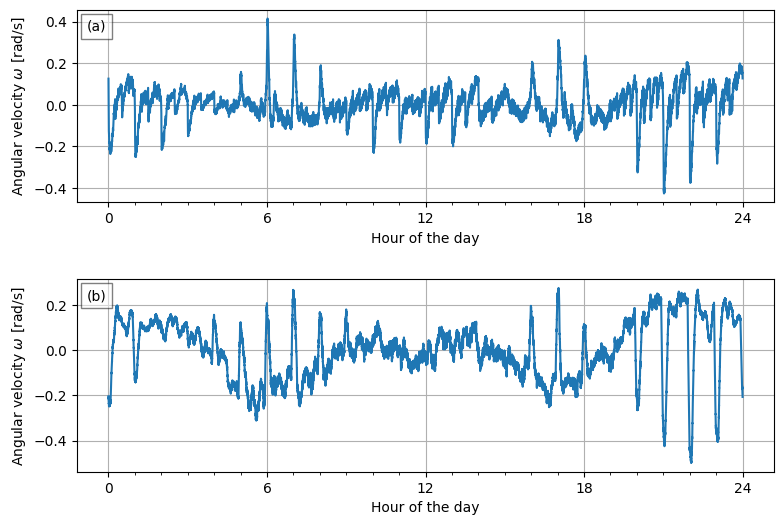

In [20]:
# combined plots of the daily profile of omega for the 2021 Continental European and the 2019 Mallorcan dataset
fig, axs = plt.subplots(2, 1, figsize=(9, 6))

# Continental European dataset
axs[0].set_xticks([0, 6, 12, 18, 24])
axs[0].set_xticks(np.arange(0, 25, 1), minor=True)
axs[0].set_xlabel("Hour of the day")
axs[0].set_ylabel("Angular velocity $\omega$ [rad/s]")
axs[0].grid()
axs[0].plot(np.arange(0, 24, 1 / 3600), df.groupby([df.index.hour, df.index.minute, df.index.second])["angular_velocity"].mean())
axs[0].text(0.014, 0.95, "(a)", transform=axs[0].transAxes, verticalalignment="top", bbox=dict(facecolor="white", alpha=0.5))

# Mallorcan dataset
axs[1].set_xticks(np.arange(0, 60 * 75 + 60 * 15, 60 * 15))
axs[1].set_xticks([0, 6, 12, 18, 24])
axs[1].set_xticks(np.arange(0, 25, 1), minor=True)
axs[1].set_xlabel("Hour of the day")
axs[1].set_ylabel("Angular velocity $\omega$ [rad/s]")
axs[1].grid()
axs[1].plot(np.arange(0, 24, 1 / 3600), df_ES_PM.groupby([df_ES_PM.index.hour, df_ES_PM.index.minute, df_ES_PM.index.second])["angular_velocity"].mean())
axs[1].text(0.014, 0.95, "(b)", transform=axs[1].transAxes, verticalalignment="top", bbox=dict(facecolor="white", alpha=0.5))

# plot settings
plt.subplots_adjust(hspace=0.4)
#plt.tight_layout()
plt.savefig("figures/daily_profile.pdf", bbox_inches="tight", format="pdf")
plt.show()

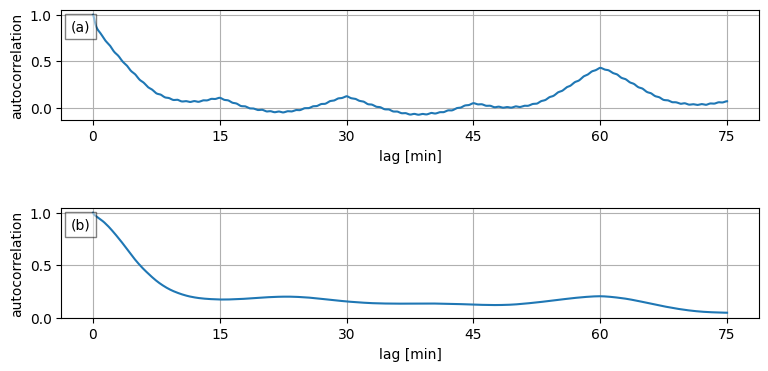

In [24]:
# combined plots of the autocorrelation function of omega for the 2021 Continental European and the 2019 Mallorcan dataset
fig, axs = plt.subplots(2, 1, figsize=(9, 4))

# Continental European dataset
axs[0].set_xticks(np.arange(0, 60 * 75 + 60 * 15, 60 * 15))
axs[0].set_xticklabels([0, 15, 30, 45, 60, 75])
axs[0].set_xlabel("lag [min]")
axs[0].set_ylabel("autocorrelation")
axs[0].grid()
axs[0].plot(acf(df["angular_velocity"], nlags=60 * 75, missing="conservative"))
axs[0].text(0.014, 0.91, "(a)", transform=axs[0].transAxes, verticalalignment="top", bbox=dict(facecolor="white", alpha=0.5))

# Mallorcan dataset
axs[1].set_xticks(np.arange(0, 60 * 75 + 60 * 15, 60 * 15))
axs[1].set_xticklabels([0, 15, 30, 45, 60, 75])
axs[1].set_xlabel("lag [min]")
axs[1].set_ylabel("autocorrelation")
axs[1].grid()
axs[1].plot(acf(df_ES_PM["angular_velocity"], nlags=60 * 75, missing="conservative"))
axs[1].text(0.014, 0.91, "(b)", transform=axs[1].transAxes, verticalalignment="top", bbox=dict(facecolor="white", alpha=0.5))

# plot settings
plt.subplots_adjust(hspace=0.8)
#plt.tight_layout()
plt.savefig("figures/autocorrelation.pdf", bbox_inches="tight", format="pdf")
plt.show()

#### Subsection "Frequency Dynamics"

C:\Users\Nicolas\AppData\Local\Temp\ipykernel_6404\1259283192.py:6: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  x = pd.date_range(start, periods=15, freq="15T")


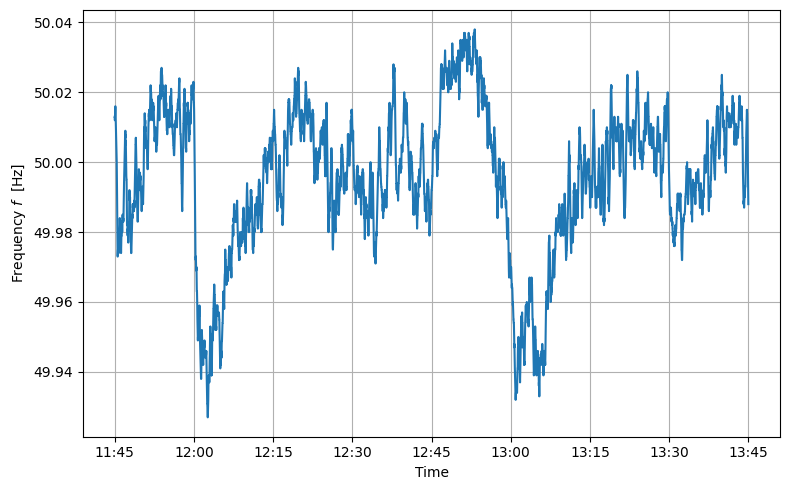

In [28]:
# we want to plot a 120min section of the angular velocity as an example
start = "2021-03-01 11:45:00"
end = "2021-03-01 13:45:00"

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
x = pd.date_range(start, periods=15, freq="15T")
ax.set_xticks(x)
ax.set_xticklabels(x.strftime("%H:%M"))
plt.plot(df["freq"][start:end])
#plt.xticks(rotation=45)
plt.xlabel("Time")
plt.ylabel("Frequency $f$  [Hz]")
plt.grid()
plt.tight_layout()
plt.savefig("figures/frequency_plot.pdf", bbox_inches="tight", format="pdf")
plt.show()

#### Power Mismatch Modelling

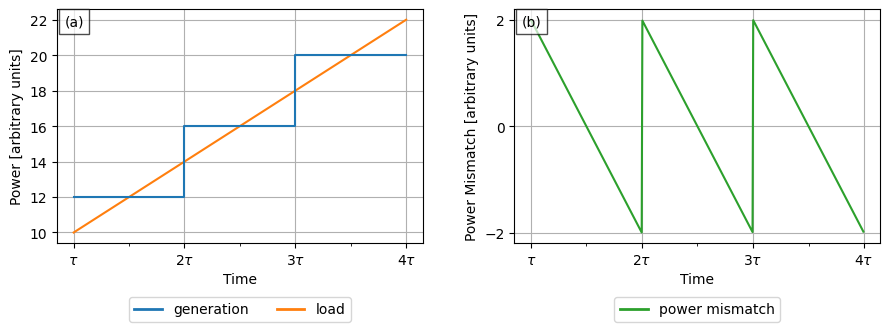

In [ ]:
# generating a plot which shows a schematic representation of the power mismatch

fig, axs = plt.subplots(1, 2, figsize=(9, 3.5))

# left subplot
x = np.array([0, 1, 2, 3])
y_load = 2 * (2 * x + 5)
y_gen = 2 * (2 * x + 5) + 2
axs[0].plot(x, y_load, color="tab:orange")
axs[0].plot(x, np.append(y_gen[:-1], y_gen[-2]), color="tab:blue", drawstyle="steps-post")
legend_handles = [Line2D([0], [0], color="tab:blue", lw=2, label="generation"),
                  Line2D([0], [0], color="tab:orange", lw=2, label="load")]
axs[0].legend(handles=legend_handles, loc="upper center", bbox_to_anchor=(0.5, -0.2), ncol=2)
axs[0].grid()
axs[0].set_xticks(x, [r"$\tau$", r"$2\tau$", r"$3\tau$", r"$4\tau$"])
axs[0].set_xticks([0.5, 1.5, 2.5], minor=True)
axs[0].set_xlabel("Time")
axs[0].set_ylabel("Power [arbitrary units]")
axs[0].text(0.02, 0.975, "(a)", transform=axs[0].transAxes, verticalalignment="top", bbox=dict(facecolor="white", alpha=0.7))

# right subplot: sawtooth function
t = np.linspace(0, 3, 500)
saw_wave = - 2 * signal.sawtooth(2 * np.pi * t)
axs[1].plot(t[:-1], saw_wave[:-1], color="tab:green")

legend_handles_2 = [Line2D([0], [0], color="tab:green", lw=2, label="power mismatch")]
axs[1].legend(handles=legend_handles_2, loc="upper center", bbox_to_anchor=(0.5, -0.2), ncol=1)
axs[1].grid()
axs[1].set_xticks([0, 1.0, 2.0, 3.0], [r"$\tau$", r"$2\tau$", r"$3\tau$", r"$4\tau$"])
axs[1].set_xticks([0.5, 1.5, 2.5], minor=True)
axs[1].set_yticks([-2, 0, 2])
axs[1].set_xlabel("Time")
axs[1].set_ylabel("Power Mismatch [arbitrary units]")
axs[1].text(0.02, 0.975, "(b)", transform=axs[1].transAxes, verticalalignment="top", bbox=dict(facecolor="white", alpha=0.7))


plt.tight_layout()
plt.subplots_adjust(wspace=0.25)
plt.savefig("figures/power_mismatch_modelling.pdf", bbox_inches="tight", format="pdf")
plt.show()